# Probabilistic Gradient Boosting
Reference: https://towardsdatascience.com/tutorial-uncertainty-estimation-with-catboost-255805ff217e

#### Idea
The most common paradigm in machine learning is to predict the expected value of the target given the input data.
#### $E[Y|X] = Model(X)$

In many applications, however, we would also like to know how uncertain our model's prediction are. That is, instead of only outputting the expected value of $Y|X$, we would like to output an entire probability distribution.

#### $P(Y|X) \sim N(Model(X),\sigma^2)$ 

In the regression setting, we usually assume the distribution of $Y|X$ is normally distributed. In this setting, we not only predict $E[Y|X]$, but also $Var[Y|X]$. If the predicted variance is large, this is an indication that the model is uncertain about the prediction. Conversely, if the predicted variance is small, the model is certain about the prediction.


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error,mean_absolute_error,r2_score
%matplotlib inline

/Users/HarrisonHoffman/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### California Housing Dataset

In [15]:
# Load data
X,y = fetch_california_housing(return_X_y=True,as_frame=True)

# Train/test split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=101)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

X_train.head()

(16512, 8)
(4128, 8)
(16512,)
(4128,)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
6560,4.7269,48.0,6.975275,1.167582,930.0,2.554945,34.19,-118.13
1071,2.2621,43.0,5.314286,1.069643,1181.0,2.108929,39.74,-121.84
11749,4.1685,20.0,6.700637,1.178344,745.0,2.372611,38.80,-121.15
13991,3.6343,28.0,6.861004,1.185328,721.0,2.783784,34.96,-117.08
17310,11.7794,39.0,14.666667,1.809524,59.0,2.809524,34.35,-119.50


#### Train Catboost 

In [18]:
params = {'iterations':2000,
          'depth':6,
          'loss_function':'RMSEWithUncertainty',
          'posterior_sampling':True,
          'verbose':False}

model = CatBoostRegressor(**params)

model.fit(X_train,y_train)

#### Evaluate Predictions

In [19]:
# We can see that the predictions are an nX2 matrix - each prediction contains a mean and variance.
preds = model.predict(X_test)
pred_means = preds[:,0]
pred_vars = preds[:,1]

print(preds.shape)
preds

(4128, 2)


array([[3.67037533, 0.14514145],
       [5.11869452, 0.01226196],
       [1.36796699, 0.03056366],
       ...,
       [2.64545037, 0.05076796],
       [2.42947312, 0.10233949],
       [3.93546178, 0.12486738]])

Mean Aboslute Error: 0.31563213792186223
Mean Aboslute Percentage Error: 0.17357841289778644
R2: 0.8247882042711631


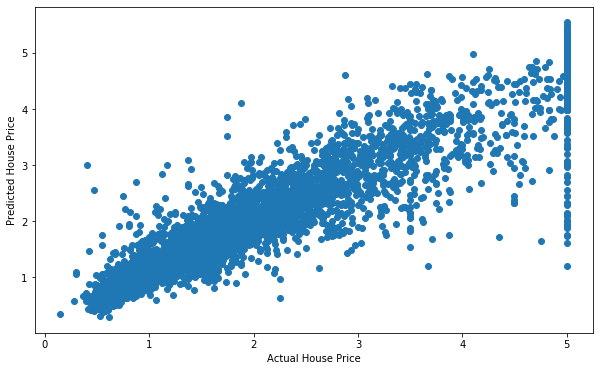

In [29]:
fig,ax = plt.subplots(figsize=(10,6))
ax.scatter(y_test,pred_means)
ax.set_xlabel("Actual House Price")
ax.set_ylabel("Predicted House Price")
print(f"Mean Aboslute Error: {mean_absolute_error(y_test,pred_means)}")
print(f"Mean Aboslute Percentage Error: {mean_absolute_percentage_error(y_test,pred_means)}")
print(f"R2: {r2_score(y_test,pred_means)}")

#### Analyze Model Uncertainty

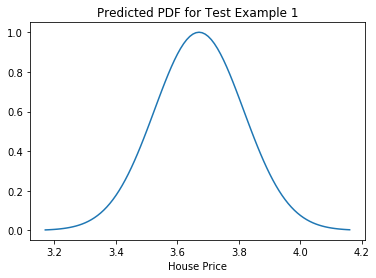

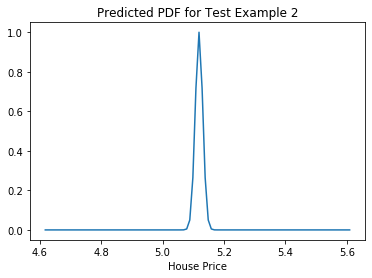

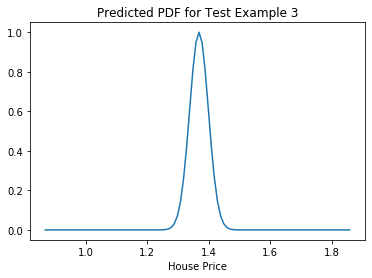

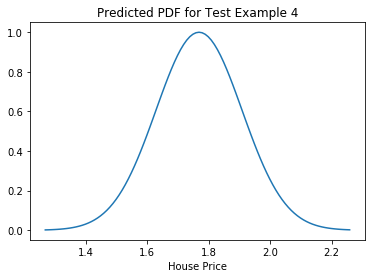

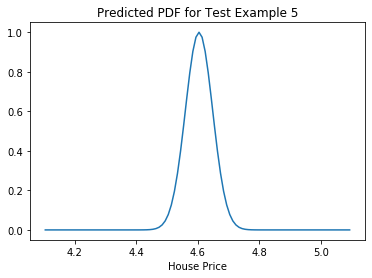

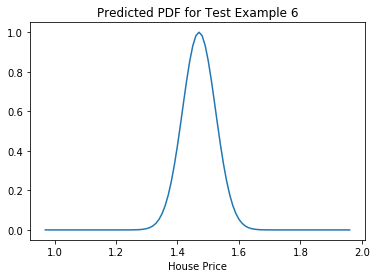

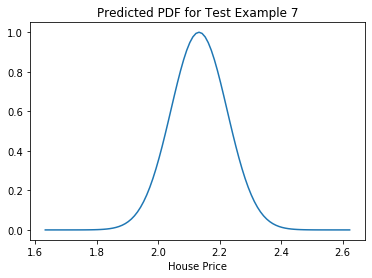

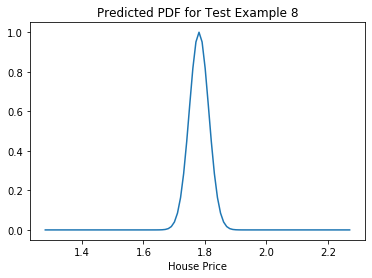

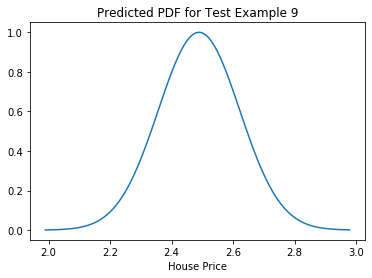

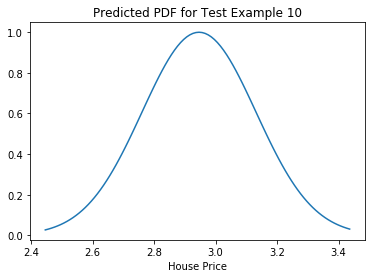

In [49]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

for i in range(10):
    
    mean = pred_means[i]
    var = pred_vars[i]
    possible_vals = np.arange(mean-0.5,mean+0.5,0.01)

    plt.plot(possible_vals,gaussian(possible_vals,mean,var))
    plt.title(f"Predicted PDF for Test Example {i+1}")
    plt.xlabel("House Price")
    plt.show()